In [ ]:
# 1) Imports
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
from sklearn.inspection import permutation_importance

Dataset shape: (12000, 33)


,patient_id,age,sex,bmi,smoking_status,pack_years,pm25_exposure,occupation,family_history,cough,...,dlco_pct_pred,cxr_finding,ct_nodule_size_mm,ct_emphysema_pct,sixmwd_m,hypertension,diabetes,hospital_visits_last_year,disease_type,severity
0,1,49,Male,20.1,Never,21.0,20.8,Office,NaN,1,...,82.1,Normal,3.0,11.9,447,1,1,0,Asthma,Moderate
1,2,61,Female,28.4,Current,34.1,10.8,Office,NaN,0,...,81.1,Normal,5.9,2.1,394,0,0,0,Lung Cancer,Mild/None
2,3,70,Male,22.2,Current,15.7,12.0,Manufacturing,NaN,1,...,85.4,Consolidation,2.8,4.8,309,0,1,0,Pneumonia,Mild/None
3,4,47,Male,23.1,Current,49.0,20.0,Manufacturing,NaN,0,...,49.0,Normal,1.8,29.4,190,0,0,0,COPD,Moderate
4,5,70,Female,29.0,Former,6.0,6.0,Office,NaN,0,...,81.6,Normal,1.0,9.5,314,0,0,0,Healthy,Mild/None


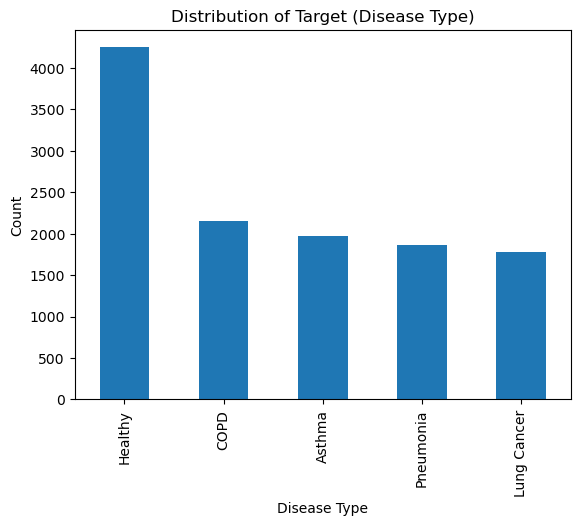

Descriptive statistics (key numeric features):


,Mean,Median,Std
crp_mg_L,20.793150,10.30,30.606319
wbc_10e9_L,8.096900,7.80,2.606807
fev1_fvc,0.740610,0.75,0.100471
fev1_pct_pred,83.805633,85.10,18.773718
ct_nodule_size_mm,4.644267,3.00,5.926454
dlco_pct_pred,81.511558,82.40,17.630906


In [3]:

# 2) Load dataset (RAW)
# ----------------------------
DATA_PATH = "lung_disease_v1.csv"   
TARGET = "disease_type"

df_raw = pd.read_csv(DATA_PATH)
print("Dataset shape:", df_raw.shape)
display(df_raw.head())


# ============================================================
# TASK 1: Exploratory Data Analysis (EDA)
# ============================================================

# ----------------------------
# 3) Target distribution (bar chart)
# ----------------------------
plt.figure()
df_raw[TARGET].value_counts().plot(kind="bar")
plt.title("Distribution of Target (Disease Type)")
plt.xlabel("Disease Type")
plt.ylabel("Count")
plt.show()


# ----------------------------
# 4) Descriptive stats (mean, median, std) for key numeric features
# ----------------------------
key_num_features = [
    "crp_mg_L",
    "wbc_10e9_L",
    "fev1_fvc",
    "fev1_pct_pred",
    "ct_nodule_size_mm",
    "dlco_pct_pred"
]

# Keep only columns that actually exist (safer)
key_num_features = [c for c in key_num_features if c in df_raw.columns]

desc = df_raw[key_num_features].agg(["mean", "median", "std"]).T
desc.columns = ["Mean", "Median", "Std"]
print("Descriptive statistics (key numeric features):")
display(desc)


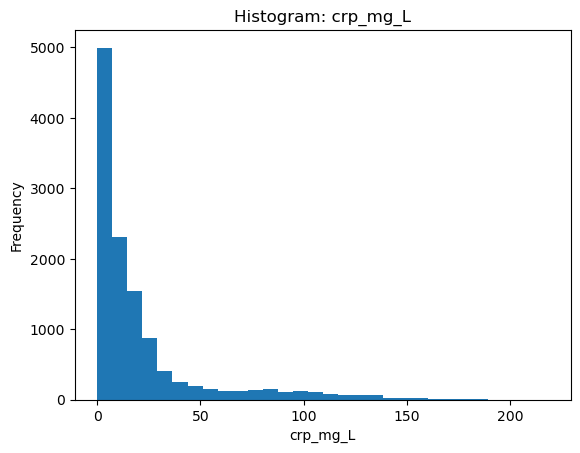

crp_mg_L skewness: 2.4008246977669283


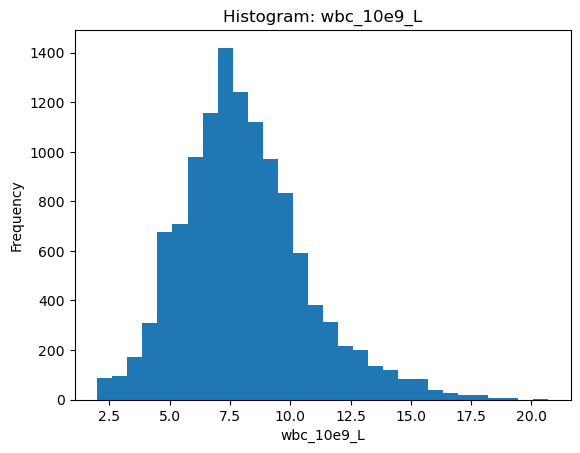

wbc_10e9_L skewness: 0.6932672819101845


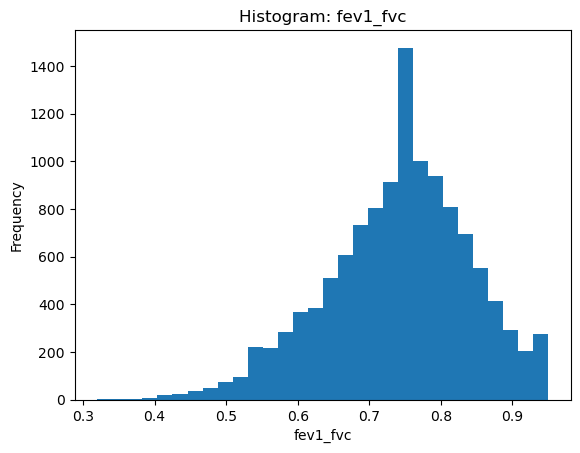

fev1_fvc skewness: -0.40111919376459826


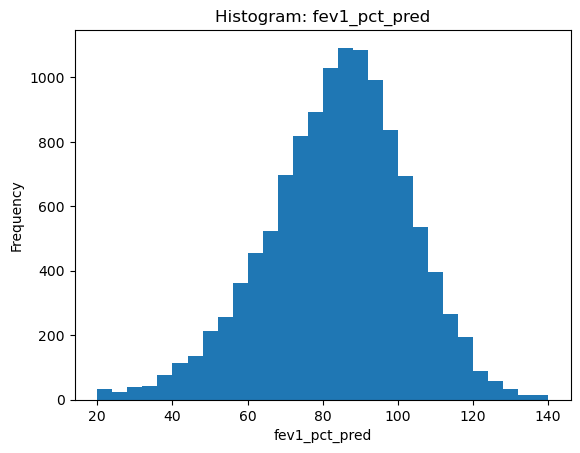

fev1_pct_pred skewness: -0.3319489144648864


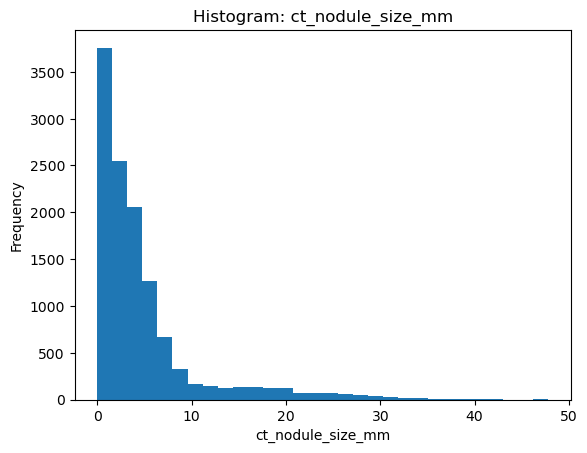

ct_nodule_size_mm skewness: 2.5063867445387125


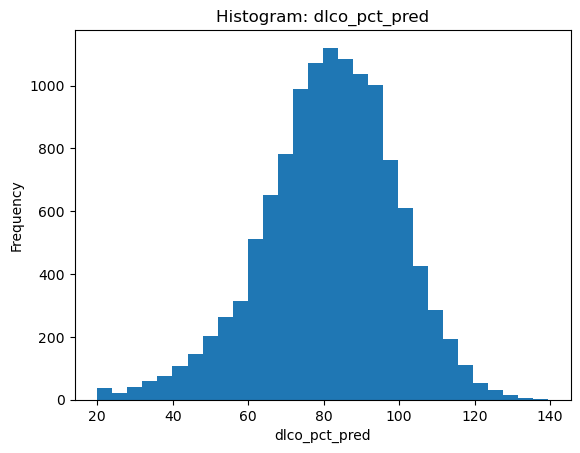

dlco_pct_pred skewness: -0.35985238753454274


In [4]:
# 5) Histograms + skewness (trends, skewness)
# ----------------------------
for col in key_num_features:
    plt.figure()
    plt.hist(df_raw[col].dropna(), bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()
    print(f"{col} skewness:", df_raw[col].dropna().skew())

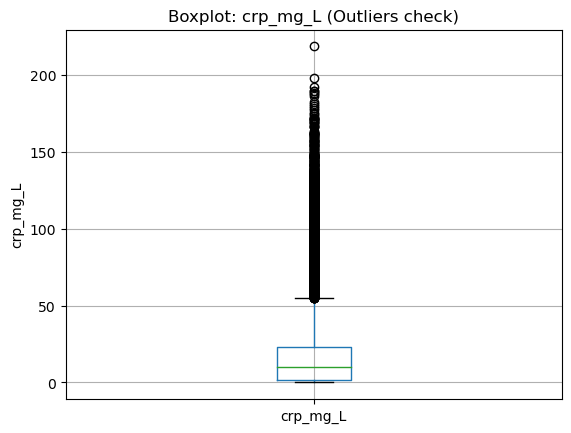

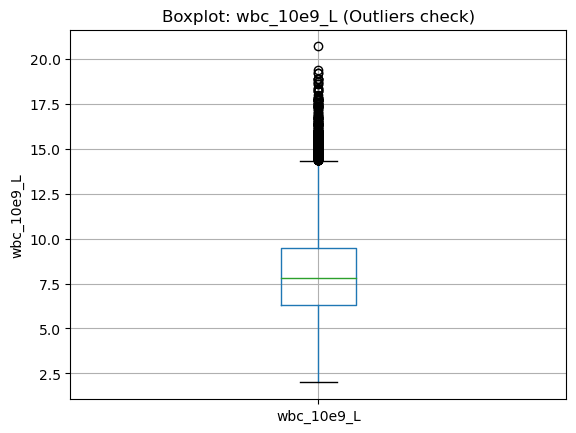

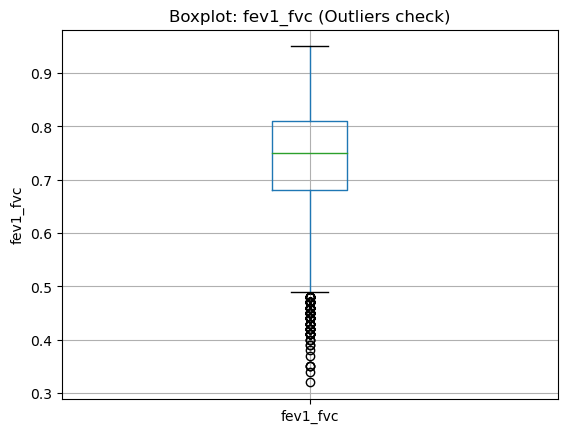

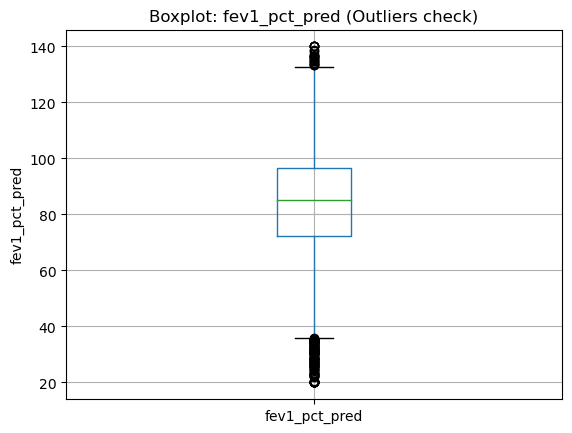

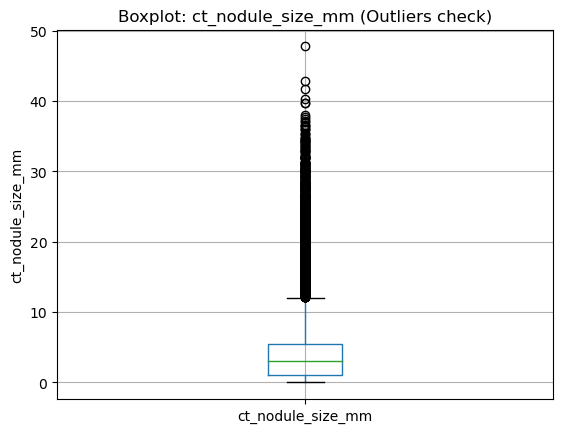

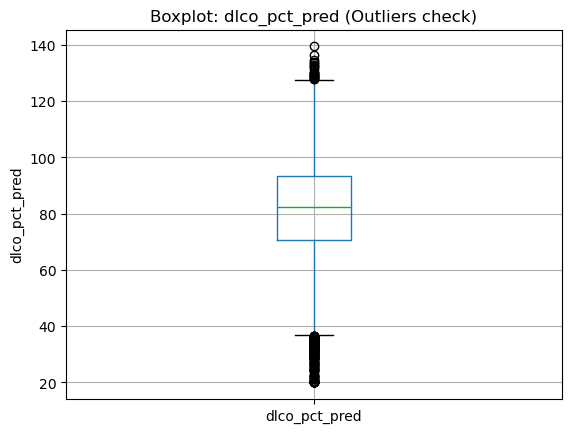

In [5]:
# 6) Boxplots (outliers) for key numeric features
# ----------------------------
for col in key_num_features:
    plt.figure()
    df_raw.boxplot(column=col)
    plt.title(f"Boxplot: {col} (Outliers check)")
    plt.suptitle("")
    plt.ylabel(col)
    plt.show()

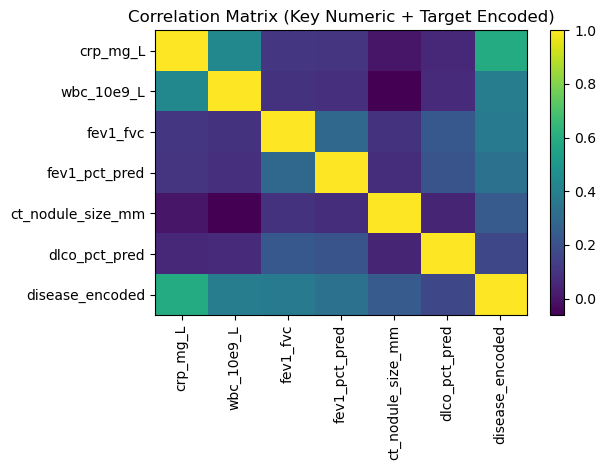

Correlation with target (encoded):


disease_encoded      1.000000
crp_mg_L             0.592178
wbc_10e9_L           0.388916
fev1_fvc             0.372064
fev1_pct_pred        0.338662
ct_nodule_size_mm    0.242620
dlco_pct_pred        0.167489
Name: disease_encoded, dtype: float64

In [6]:
# 7) Correlation: numeric features + target (encoded)
# ----------------------------
df_eda = df_raw.copy()
df_eda["disease_encoded"] = df_eda[TARGET].astype("category").cat.codes

corr_cols = key_num_features + ["disease_encoded"]
corr = df_eda[corr_cols].corr(numeric_only=True)

plt.figure()
plt.imshow(corr, aspect="auto")
plt.title("Correlation Matrix (Key Numeric + Target Encoded)")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.colorbar()
plt.tight_layout()
plt.show()

print("Correlation with target (encoded):")
display(corr["disease_encoded"].sort_values(ascending=False))

Median values by disease category:


,crp_mg_L,wbc_10e9_L,fev1_fvc,fev1_pct_pred,ct_nodule_size_mm,dlco_pct_pred
disease_type,,,,,,
Asthma,5.3,7.5,0.71,78.2,2.9,84.75
COPD,12.3,7.5,0.63,65.4,3.0,64.80
Healthy,4.9,7.5,0.78,90.0,2.1,85.60
Lung Cancer,16.7,7.5,0.78,90.0,15.1,85.00
Pneumonia,77.2,11.6,0.78,89.8,3.0,85.40


<Figure size 640x480 with 0 Axes>

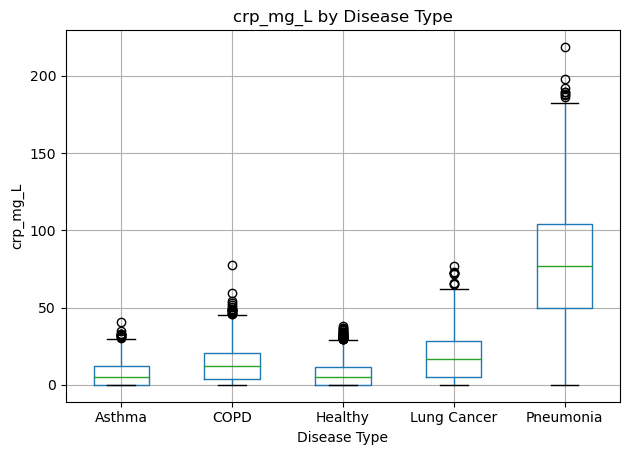

<Figure size 640x480 with 0 Axes>

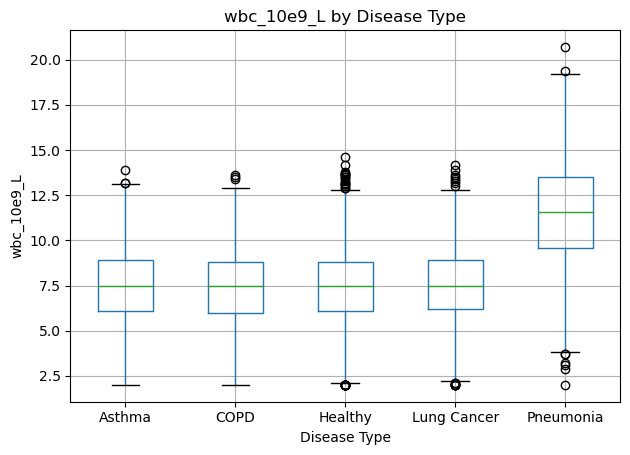

<Figure size 640x480 with 0 Axes>

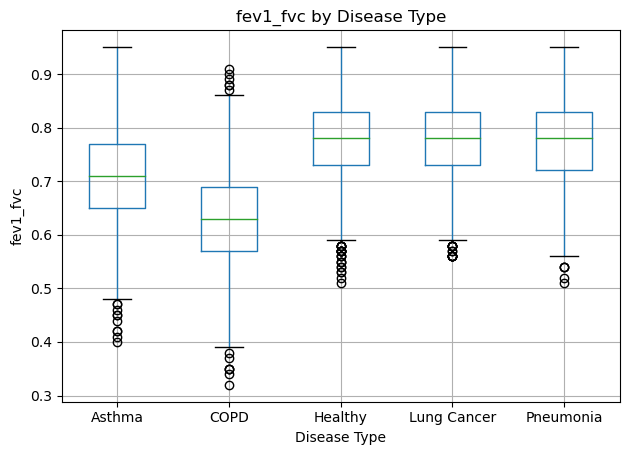

In [7]:
# 8) Features linked to disease categories:
#    - Group-by median table
#    - Disease-wise boxplots (strong evidence)
# ----------------------------
print("Median values by disease category:")
display(df_raw.groupby(TARGET)[key_num_features].median(numeric_only=True))

for col in key_num_features[:3]:  # keep it neat (2–3 strongest features)
    plt.figure()
    df_raw.boxplot(column=col, by=TARGET)
    plt.title(f"{col} by Disease Type")
    plt.suptitle("")
    plt.xlabel("Disease Type")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


In [8]:
# TASK 2: Data Preparation
# ============================================================

# ----------------------------
# 9) Missing values BEFORE (explicit)
# ----------------------------
missing_before = df_raw.isna().sum().sort_values(ascending=False)
print("Missing values BEFORE preprocessing (top 15):")
display(missing_before.head(15))

# For a clear before/after demo, we show the key missing column if present:
if "family_history" in df_raw.columns:
    print("family_history missing BEFORE:", int(df_raw["family_history"].isna().sum()))

Missing values BEFORE preprocessing (top 15):


family_history               7176
ct_nodule_size_mm               0
wbc_10e9_L                      0
fev1_fvc                        0
fev1_pct_pred                   0
fvc_pct_pred                    0
dlco_pct_pred                   0
cxr_finding                     0
patient_id                      0
respiratory_rate                0
ct_emphysema_pct                0
sixmwd_m                        0
hypertension                    0
diabetes                        0
hospital_visits_last_year       0
dtype: int64

family_history missing BEFORE: 7176


In [10]:
# 10) Define X, y (use RAW)
# ----------------------------
X_raw = df_raw.drop(columns=[TARGET])
y = df_raw[TARGET]
# 11) Identify numeric vs categorical columns
# ----------------------------
num_cols = X_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_raw.select_dtypes(include=["object"]).columns.tolist()

print("Numeric cols:", len(num_cols), "| Categorical cols:", len(cat_cols))

Numeric cols: 26 | Categorical cols: 6


In [11]:
# 12) Preprocessing pipeline:
#     - Numeric: median impute + standardize
#     - Categorical: most_frequent impute + one-hot encode
# ----------------------------
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)

# ----------------------------
# 13) BEFORE/AFTER examples (missingness + scaling)
#     We do a clean demo by fitting the preprocessor once and checking results.
# ----------------------------
X_processed_full = preprocessor.fit_transform(X_raw)

# AFTER: missingness check on processed matrix (should be no NaN)
nan_after = np.isnan(X_processed_full.toarray() if hasattr(X_processed_full, "toarray") else X_processed_full).sum()
print("Total NaNs AFTER preprocessing (should be 0):", int(nan_after))

Total NaNs AFTER preprocessing (should be 0): 0


In [12]:
# AFTER: scaling check (numeric part ~ mean 0, std 1)
X_num_scaled = preprocessor.named_transformers_["num"].transform(X_raw[num_cols])
print("Numeric features AFTER scaling (approx):")
print("Mean (first 6):", np.round(X_num_scaled.mean(axis=0)[:6], 4))
print("Std  (first 6):", np.round(X_num_scaled.std(axis=0)[:6], 4))

Numeric features AFTER scaling (approx):
Mean (first 6): [ 0.  0.  0.  0. -0. -0.]
Std  (first 6): [1. 1. 1. 1. 1. 1.]


In [13]:
# TASK 3: Model Training (6 models)
# ============================================================

# ----------------------------
# 14) Train-test split (80/20, stratify)
# ----------------------------
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train_raw.shape, "Test size:", X_test_raw.shape)

Train size: (9600, 32) Test size: (2400, 32)


In [14]:
# 15) Define 6 models (default hyperparameters)
# ----------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),  # for ROC
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Build full pipelines so every model uses SAME preprocessing
pipelines = {
    name: Pipeline(steps=[("prep", preprocessor), ("model", model)])
    for name, model in models.items()
}

In [15]:
# ----------------------------
# 16) Record initial hyperparameters (before tuning)
# ----------------------------
print("\nInitial hyperparameters (before tuning):")
for name, pipe in pipelines.items():
    print(f"\n--- {name} ---")
    print(pipe.named_steps["model"].get_params())


Initial hyperparameters (before tuning):

--- Logistic Regression ---
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

--- SVM ---
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

--- Decision Tree ---
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

--- Random Forest ---
{'bootstrap': True, 'ccp_alpha': 0

In [16]:
# 17) Train all models + evaluate (comparative table)
# ----------------------------
rows = []
trained_pipes = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train_raw, y_train)
    trained_pipes[name] = pipe

    y_pred = pipe.predict(X_test_raw)

    rows.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "Recall_macro": recall_score(y_test, y_pred, average="macro", zero_division=0),
        "F1_macro": f1_score(y_test, y_pred, average="macro", zero_division=0),
    })

results_df = pd.DataFrame(rows).sort_values("F1_macro", ascending=False)
print("\nModel comparison table:")
display(results_df)




Model comparison table:


,Model,Accuracy,Precision_macro,Recall_macro,F1_macro
0,Logistic Regression,0.943750,0.950694,0.940154,0.944978
3,Random Forest,0.943333,0.953281,0.937364,0.944314
5,Gradient Boosting,0.937500,0.945357,0.932268,0.938176
1,SVM,0.936250,0.945848,0.929649,0.937133
2,Decision Tree,0.892917,0.894668,0.896246,0.895073
4,KNN,0.862500,0.894070,0.837725,0.860712


Best baseline model: Logistic Regression


<Figure size 640x480 with 0 Axes>

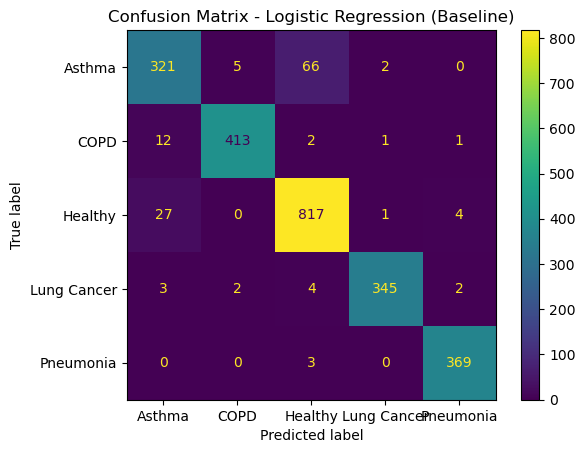

In [17]:
# TASK 4: Model Evaluation & Visualization
# ============================================================

# ----------------------------
# 18) Confusion Matrix (best baseline model)
# ----------------------------
best_baseline_name = results_df.iloc[0]["Model"]
best_baseline_pipe = trained_pipes[best_baseline_name]
print("Best baseline model:", best_baseline_name)

plt.figure()
ConfusionMatrixDisplay.from_estimator(best_baseline_pipe, X_test_raw, y_test)
plt.title(f"Confusion Matrix - {best_baseline_name} (Baseline)")
plt.show()


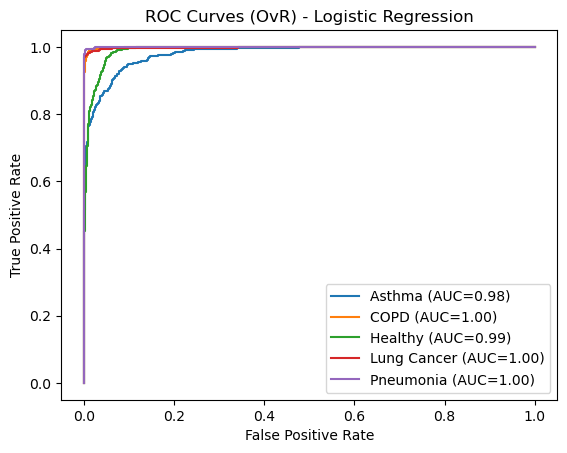

In [18]:
# 19) ROC Curves (One-vs-Rest)
#     Uses predict_proba from each pipeline
# ----------------------------
classes = np.sort(y.unique())
y_test_bin = label_binarize(y_test, classes=classes)

# Some models may not have predict_proba; we ensured SVM(probability=True), others do.
y_score = best_baseline_pipe.predict_proba(X_test_raw)

plt.figure()
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.2f})")

plt.title(f"ROC Curves (OvR) - {best_baseline_name}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [21]:
# 20) Hyperparameter tuning (GridSearchCV) on Random Forest
#     (You can tune the best model too, but RF is a strong standard choice)
# ----------------------------
rf_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5]
}

grid = GridSearchCV(rf_pipe, param_grid=param_grid, scoring="f1_macro", cv=3, n_jobs=1)


grid.fit(X_train_raw, y_train)
print("Best RF params:", grid.best_params_)
print("Best CV f1_macro:", grid.best_score_)

Best RF params: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best CV f1_macro: 0.945328342415095


In [22]:
# 21) Compare performance BEFORE vs AFTER tuning (on test set)
# ----------------------------
# Baseline RF (already trained above if present)
baseline_rf_pipe = trained_pipes.get("Random Forest")
if baseline_rf_pipe is not None:
    y_pred_rf_base = baseline_rf_pipe.predict(X_test_raw)
    rf_base_f1 = f1_score(y_test, y_pred_rf_base, average="macro", zero_division=0)
else:
    rf_base_f1 = None

tuned_rf_pipe = grid.best_estimator_
y_pred_rf_tuned = tuned_rf_pipe.predict(X_test_raw)
rf_tuned_f1 = f1_score(y_test, y_pred_rf_tuned, average="macro", zero_division=0)

print("\nRandom Forest comparison (Test set):")
print("Baseline RF F1_macro:", rf_base_f1)
print("Tuned RF F1_macro:", rf_tuned_f1)


Random Forest comparison (Test set):
Baseline RF F1_macro: 0.9443140692792997
Tuned RF F1_macro: 0.9416844915232829


In [23]:
# 22) Get feature names after preprocessing (important for readable plots)
# ----------------------------
def get_feature_names(preprocessor_obj):
    # numeric feature names
    num_features = preprocessor_obj.named_transformers_["num"].feature_names_in_.tolist()

    # categorical feature names after one-hot
    ohe = preprocessor_obj.named_transformers_["cat"].named_steps["onehot"]
    cat_features = preprocessor_obj.named_transformers_["cat"].feature_names_in_.tolist()
    cat_ohe_features = ohe.get_feature_names_out(cat_features).tolist()

    return num_features + cat_ohe_features

feature_names = get_feature_names(preprocessor)
print("Total transformed features:", len(feature_names))


Total transformed features: 52


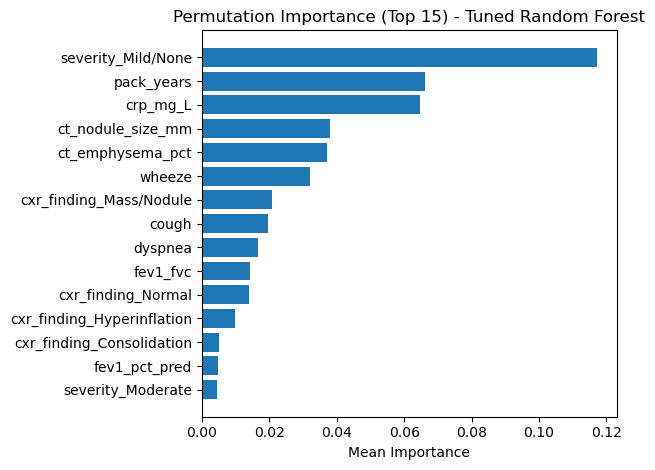

In [26]:
# 23) Permutation Importance (on tuned RF) – ranked + plot (clean)
# ----------------------------
# Need transformed X for permutation importance (uses fitted preprocessor inside tuned pipeline)

# Transform test data using the fitted preprocessor
X_test_transformed = tuned_rf_pipe.named_steps["prep"].transform(X_test_raw)

perm = permutation_importance(
    tuned_rf_pipe.named_steps["model"],
    X_test_transformed,
    y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=1   # IMPORTANT: avoid multiprocessing crash
)

importances_mean = perm.importances_mean
top_idx = np.argsort(importances_mean)[-15:]  # top 15

plt.figure()
plt.barh(range(len(top_idx)), importances_mean[top_idx])
plt.yticks(range(len(top_idx)), [feature_names[i] for i in top_idx])
plt.title("Permutation Importance (Top 15) - Tuned Random Forest")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()


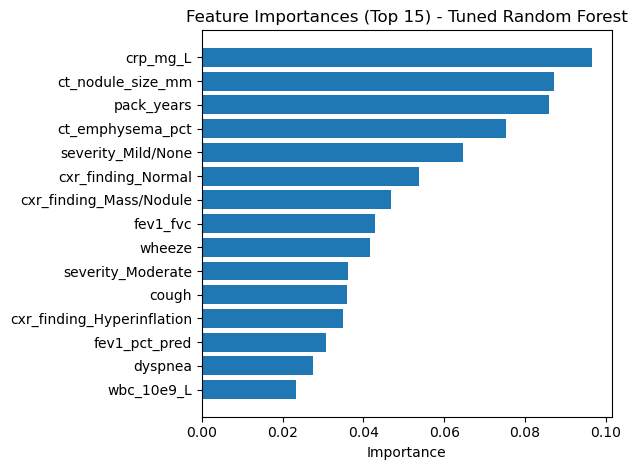

In [27]:
# 24) Random Forest built-in feature_importances_ (Top 15)
# ----------------------------
rf_importances = tuned_rf_pipe.named_steps["model"].feature_importances_
top_idx2 = np.argsort(rf_importances)[-15:]

plt.figure()
plt.barh(range(len(top_idx2)), rf_importances[top_idx2])
plt.yticks(range(len(top_idx2)), [feature_names[i] for i in top_idx2])
plt.title("Feature Importances (Top 15) - Tuned Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

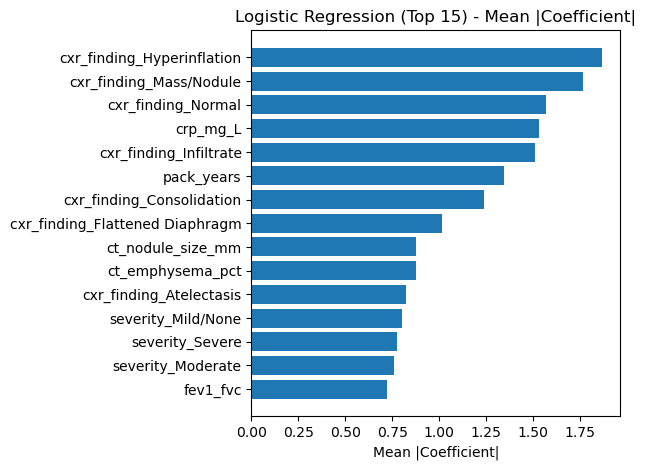

In [28]:
# 25) Logistic Regression coefficients (global importance via mean |coef|)
# ----------------------------
# Fit LR pipeline (already trained; use trained version)
lr_pipe = trained_pipes["Logistic Regression"]
lr_model = lr_pipe.named_steps["model"]

X_test_lr = lr_pipe.named_steps["prep"].transform(X_test_raw)
# Coefs shape: (n_classes, n_features) for multiclass
coef_abs_mean = np.mean(np.abs(lr_model.coef_), axis=0)
top_idx3 = np.argsort(coef_abs_mean)[-15:]

plt.figure()
plt.barh(range(len(top_idx3)), coef_abs_mean[top_idx3])
plt.yticks(range(len(top_idx3)), [feature_names[i] for i in top_idx3])
plt.title("Logistic Regression (Top 15) - Mean |Coefficient|")
plt.xlabel("Mean |Coefficient|")
plt.tight_layout()
plt.show()